# Supervised Classification for GRS1915+105 Light curves

In this notebook, we'll do some supervised classification on light curves of GRS 1915+105.
Let's get started!

First, we need some features. The details of feature extraction are explained in the accompanying notebook `GRS1915_Feature_Extraction.ipynb`. Here, we'll assume you've worked your way through that, and are ready to work with a feature vector you've made in there.

Therefore, we'll just load said feature vector:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import sklearn
import pickle
import feature_extraction
import generaltools as gt

datadir = "/scratch/daniela/data/grs1915/"

In [3]:
def transform_chi(labels):
    labels[labels == "chi1"] = "chi"
    labels[labels == "chi2"] = "chi"
    labels[labels == "chi3"] = "chi"
    labels[labels == "chi4"] = "chi"
    return labels



In [4]:
seg_length_supervised = 1024.

features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_supervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_supervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_supervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_supervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_supervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_supervised)[0])

labels_train_full = transform_chi(labels_train_full)
labels_test_full = transform_chi(labels_test_full)
labels_val_full = transform_chi(labels_val_full)

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_supervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_supervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_supervised)

features_all_full = np.concatenate((features_train_full, features_val_full, features_test_full))

features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val= features_val_full[np.where(labels_val_full != "None")]

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]

labels_train = transform_chi(labels_train)
labels_test = transform_chi(labels_test)
labels_val = transform_chi(labels_val)


In [5]:
lc_all_full = gt.getpickle(datadir+"grs1915_%is_lc_all.dat"%seg_length_supervised)
hr_all_full = gt.getpickle(datadir+"grs1915_%is_hr_all.dat"%seg_length_supervised)

lc_train_full = lc_all_full["train"]
lc_test_full = lc_all_full["test"]
lc_val_full = lc_all_full["val"]

hr_train_full = hr_all_full["train"]
hr_test_full = hr_all_full["test"]
hr_val_full = hr_all_full["val"]

In [6]:
features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val= features_val_full[np.where(labels_val_full != "None")]

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]


In [7]:
train_ind = np.where(labels_train_full != "None")[0]
lc_train = np.array([lc_train_full[i] for i in train_ind])
hr_train = np.array([hr_train_full[i] for i in train_ind])

val_ind = np.where(labels_val_full != "None")[0]
lc_val = np.array([lc_val_full[i] for i in val_ind])
hr_val = np.array([hr_val_full[i] for i in val_ind])

test_ind = np.where(labels_test_full != "None")[0]
lc_test = np.array([lc_test_full[i] for i in test_ind])
hr_test = np.array([hr_test_full[i] for i in test_ind])


We'll also load the feature engineering results from the greedy search:

In [8]:
with open(datadir+"grs1915_greedysearch_res.dat" ,'r') as f:
    data = pickle.load(f)

In [9]:
scores = data["scores"]
ranking = data["ranking"]

In [10]:
max_scores = []
for s in scores:
    max_scores.append(np.max(s))

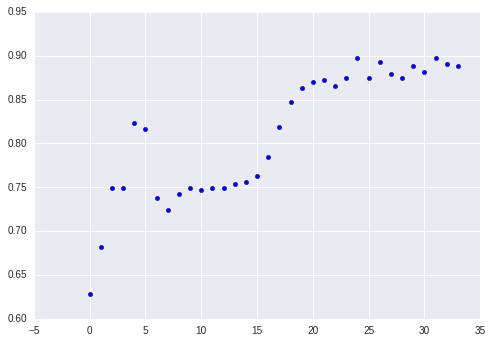

In [11]:
plt.scatter(np.arange(len(max_scores)), max_scores, marker="o")

In [12]:
ranking

[10,
 30,
 26,
 0,
 31,
 1,
 4,
 6,
 33,
 20,
 3,
 22,
 28,
 23,
 18,
 12,
 32,
 29,
 21,
 15,
 16,
 13,
 2,
 14,
 24,
 8,
 25,
 19,
 17,
 27,
 9,
 7,
 11,
 5]

In [13]:
features_train_full.shape

(4269, 34)

In [14]:
features_train_new = np.array([features_train_full[:,i] for i in ranking]).T
features_test_new = np.array([features_test_full[:,i] for i in ranking]).T
features_val_new = np.array([features_val_full[:,i] for i in ranking]).T

ftrain_labelled = features_train_new[train_ind]
ftest_labelled = features_test_new[test_ind]
fval_labelled = features_val_new[val_ind]

To do the supervised learning, we will scale the data to a mean of zero and unit variance.

In [15]:
from sklearn import cross_validation 
from sklearn.preprocessing import StandardScaler

# concatenate labelled features
features_all_new = np.concatenate((features_train_new, features_val_new, features_test_new))
labels_all = np.concatenate([labels_train_full, labels_val_full, labels_test_full])

# fit scaler to *all* features
scaler_train = StandardScaler().fit(features_all_new)

# scale training, validation and test sets
fscaled_train = scaler_train.transform(ftrain_labelled) 
fscaled_val = scaler_train.transform(fval_labelled)
fscaled_test = scaler_train.transform(ftest_labelled)

fscaled_train_full = scaler_train.transform(features_train_new) 
fscaled_val_full = scaler_train.transform(features_val_new)
fscaled_test_full = scaler_train.transform(features_test_new)





## Visualization

Let's start with some visualization.

We'll plot all features against all other features in simple scatter plots:

In [16]:
def scatter(f1_full, f2_full, labels, log1=False, log2=False, alpha=0.5, palette="Set3"):
    if log1:
        f1 = np.log(f1_full)
    else:
        f1 = f1_full
        
    if log2:
        f2 = np.log(f2_full)
    else:
        f2 = f2_full
        
    f1_labelled = f1[labels != "None"]
    f2_labelled = f2[labels != "None"]
    
    unique_labels = np.unique(labels)
    unique_labels = np.delete(unique_labels, np.where(unique_labels == "None")[0])
    #print("unique labels : " + str(unique_labels))
    
    # make a Figure object
    fig, ax = plt.subplots(1,1,figsize=(12,9))
    
    # first plot the unclassified examples:
    ax.scatter(f1[labels == "None"], f2[labels == "None"], color="grey", alpha=alpha)

    # now make a color palette:
    current_palette = sns.color_palette(palette, len(unique_labels))
    
    for l, c in zip(unique_labels, current_palette):
        ax.scatter(f1[labels == l], f2[labels == l], color=c, alpha=alpha, label=l)
        
    plt.legend()
    
    return fig, ax
    
    

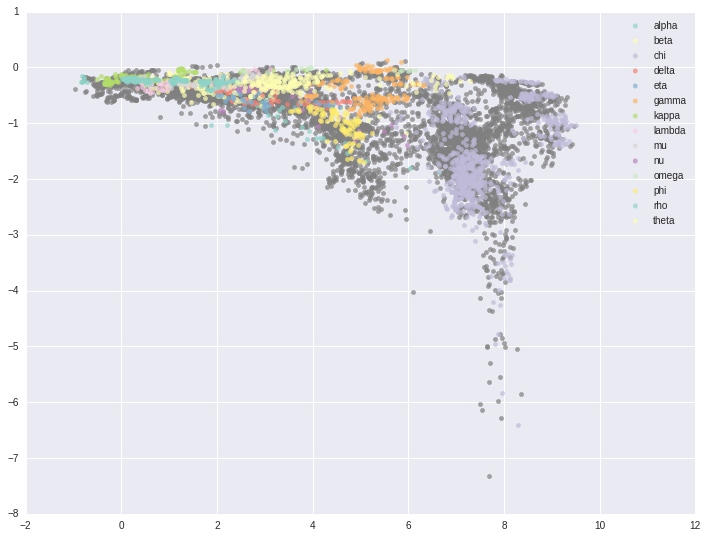

In [17]:
fig, ax = scatter(features_all_new[:,0], features_all_new[:,1], 
                  labels_all, log1=True, log2=True, alpha=0.7)

Now we can run this for all features. Let's first start with `log1` and `log2` being `False`.

An initial run suggests that there's a single, weird outlier in a light curve in features 17,18,19 and 20 (skew and kurtosis if hardness ratios). Let's find it and exclude that single outlier:

In [18]:
print(np.where(features_all_full[:,16] >= 20)[0])
print(np.where(features_all_full[:,17] >= 20)[0])
print(np.where(features_all_full[:,18] >= 600)[0])
print(np.where(features_all_full[:,19] >= 800)[0])
print(len(features_train_full))
print(len(features_val_full))
print(len(features_test_full))
delete_ind = np.where(features_all_full[:,17] >= 20)[0]

[]
[8032]
[]
[]
4269
2148
2090


In [19]:
delete_ind -= len(features_train_full)
delete_ind -= len(features_val_full)
print(delete_ind)

[1615]


This is a sample from the test data set.

So let's exclude it both from the training data set and the full data set:

In [20]:
features_test_full = np.delete(features_test_full, delete_ind, axis=0)
features_all_full = np.concatenate((features_train_full, features_val_full, features_test_full))

labels_test_full = np.delete(labels_test_full, delete_ind, axis=0)
labels_test_full = transform_chi(labels_test_full)

features_test = features_test_full[np.where(labels_test_full != "None")]
labels_test= labels_test_full[np.where(labels_test_full != "None")]
labels_test = transform_chi(labels_test)

lc_test_full = np.delete(lc_test_full, delete_ind, axis=0)
hr_test_full = np.delete(hr_test_full, delete_ind, axis=0)
tstart_test_full = np.delete(tstart_test_full, delete_ind, axis=0)

features_test = features_test_full[np.where(labels_test_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]

test_ind = np.where(labels_test_full != "None")[0]
lc_test = np.array([lc_test_full[i] for i in test_ind])
hr_test = np.array([hr_test_full[i] for i in test_ind])

features_test_new = np.array([features_test_full[:,i] for i in ranking]).T
ftest_labelled = features_test_new[test_ind]

# concatenate labelled features
features_all_new = np.concatenate((features_train_new, features_val_new, features_test_new))
labels_all = np.concatenate([labels_train_full, labels_val_full, labels_test_full])

# fit scaler to *all* features
scaler_train = StandardScaler().fit(features_all_new)

# scale training, validation and test sets
fscaled_train = scaler_train.transform(ftrain_labelled) 
fscaled_val = scaler_train.transform(fval_labelled)
fscaled_test = scaler_train.transform(ftest_labelled)

fscaled_train_full = scaler_train.transform(features_train_new) 
fscaled_val_full = scaler_train.transform(features_val_new)
fscaled_test_full = scaler_train.transform(features_test_new)


In [21]:
print(np.where(features_all_full[:,16] >= 20)[0])
print(np.where(features_all_full[:,17] >= 20)[0])
print(np.where(features_all_full[:,18] >= 600)[0])
print(np.where(features_all_full[:,19] >= 800)[0])


[]
[]
[]
[]


In [262]:
nfeatures = features_all_full.shape[1]
print("There are %i features in total."%nfeatures)

log_features = [2, 5, 6, 7, 9, 10, 11, 14, 16]

for i in range(nfeatures):
    for j in range(nfeatures):
        if i >= j: 
            continue
        else:
            if i in log_features:
                log1 = True
            else: 
                log1 = False
            
            if j in log_features:
                log2 = True
            else:
                log2 = False
            #print("Running on features %i and %i."%(i,j))
            #fig, ax = scatter(features_all_full[:,i], features_all_full[:,j], 
            #                  labels_all, log1=log1, log2=log2, alpha=0.7)
            #ax.set_xlabel("Feature %i"%i)
            #ax.set_ylabel("Feauter %i"%j)

There are 34 features in total.


For classification, the following features should be log-scaled:
* total variance in the light curve (2)
* frequency of maximum power in the PSD (5)
* power spectral band A (6)
* power spectral band B (7)
* power spectral band D (9)
* PSD colour 1 (10)
* PSD colour 2 (11)
* variance of HR1 (14)
* variance of HR 2(16)

Let's do that, then.

In [22]:
log_features = [2, 5, 6, 7, 9, 10, 11, 14, 16]

for l in log_features:
    features_train_full[:,l] = np.log(features_train_full[:,l])
    features_test_full[:,l] = np.log(features_test_full[:,l])
    features_val_full[:,l] = np.log(features_val_full[:,l])
    
    
features_all_full = np.concatenate((features_train_full, features_val_full, features_test_full))

features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val = features_val_full[np.where(labels_val_full != "None")]

features_train_new = np.array([features_train_full[:,i] for i in ranking]).T
features_test_new = np.array([features_test_full[:,i] for i in ranking]).T
features_val_new = np.array([features_val_full[:,i] for i in ranking]).T

# concatenate labelled features
features_all_new = np.concatenate((features_train_new, features_val_new, features_test_new))

ftrain_labelled = features_train_new[labels_train_full != "None"]
ftest_labelled = features_test_new[labels_test_full != "None"]
fval_labelled = features_val_new[labels_val_full != "None"]



In [23]:
# fit scaler to *all* features
scaler_train = StandardScaler().fit(features_all_new)

# scale training, validation and test sets
fscaled_train = scaler_train.transform(ftrain_labelled) 
fscaled_val = scaler_train.transform(fval_labelled)
fscaled_test = scaler_train.transform(ftest_labelled)

fscaled_train_full = scaler_train.transform(features_train_new) 
fscaled_val_full = scaler_train.transform(features_val_new)
fscaled_test_full = scaler_train.transform(features_test_new)




### Reading the prepared data in from file?

I have some functions in `feature_engineering.py` to do some of this automatically.

In [38]:
import feature_engineering

In [39]:
features, labels, lc, hr, tstart = feature_engineering.load_features(datadir, 1024., ranking=ranking)

delete_ind: [8032]
delete_ind_new: [1615]
delete_set: test
after removal: []


That did basically everything above automatically, including reordering according to the feature ranking. Let's also extract the data that have labels:

In [40]:
features_lb, labels_lb, lc_lb, hr_lb, tstart_lb = feature_engineering.labelled_data(features, labels,
                                                                                   lc, hr, tstart)

Now we only need to scale these features, and we're ready to go!

In [41]:
fscaled, fscaled_lb = feature_engineering.scale_features(features, features_lb)

In [42]:
fscaled["train"]

array([[ 0.99056346, -1.38540918,  0.65702717, ..., -0.27280872,
        -1.06367628,  0.6064799 ],
       [ 1.02718861, -1.39601656,  0.69659898, ..., -0.30761375,
        -1.09703241,  0.56448438],
       [ 0.9439149 , -1.37559952,  0.60807639, ..., -0.21653191,
        -1.03852689,  0.56448438],
       ..., 
       [-0.11034385, -0.71520789,  0.52608825, ..., -0.85583164,
        -0.24495229,  0.80323261],
       [ 1.23334189,  0.7420108 , -0.75543582, ..., -0.55288509,
        -0.35293844, -0.02052503],
       [ 1.24667713,  0.81498922, -0.91110157, ..., -0.51623808,
        -0.32558945, -0.02052503]])

What happens if I do a simple PCA decomposition of my features?

In [45]:
from sklearn.decomposition import PCA

fscaled_full = np.vstack([fscaled["train"], fscaled["val"], fscaled["test"]])

labels_all = np.hstack([labels["train"], labels["val"], labels["test"]])

In [44]:
pc = PCA(n_components=2)
fscaled_pca = pc.fit(fscaled_full).transform(fscaled_full)

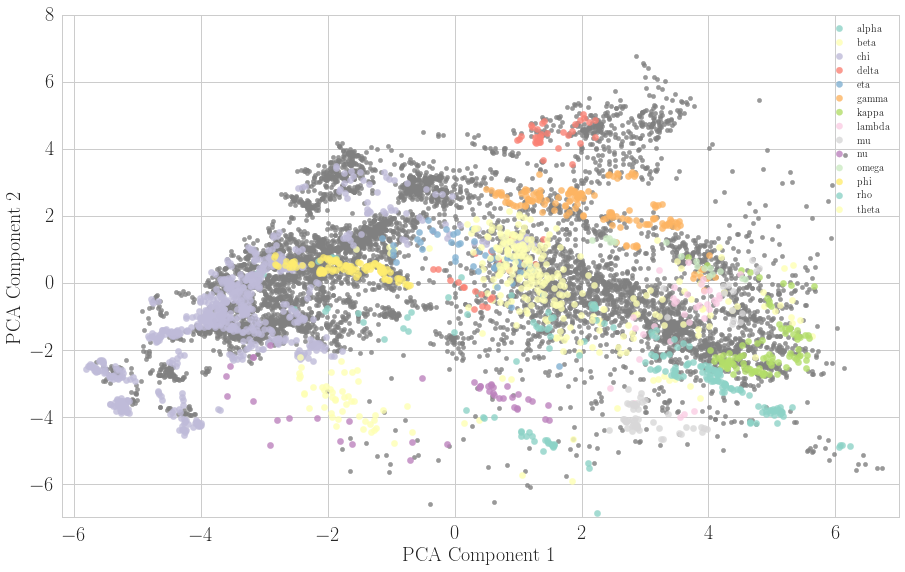

In [51]:
alpha=0.8
palette = "Set3"

sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

unique_labels = np.unique(labels_all)
unique_labels = np.delete(unique_labels, np.where(unique_labels == "None")[0])
#print("unique labels : " + str(unique_labels))

# make a Figure object
fig, ax = plt.subplots(1,1,figsize=(15,9))

# first plot the unclassified examples:
ax.scatter(fscaled_pca[labels_all == "None",0], fscaled_pca[labels_all == "None",1], color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax.scatter(fscaled_pca[labels_all == l,0], fscaled_pca[labels_all == l,1], s=40,
               color=c, alpha=alpha, label=l)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(-6.2, 7.0)
plt.ylim(-7.0, 8.0)
plt.legend()


I also have a handy function that can make this plot:

In [52]:
import grs1915_dataviz

In [76]:
reload(grs1915_dataviz)

<module 'grs1915_dataviz' from 'grs1915_dataviz.py'>

delete_ind: [8032]
delete_ind_new: [1615]
delete_set: test
after removal: []


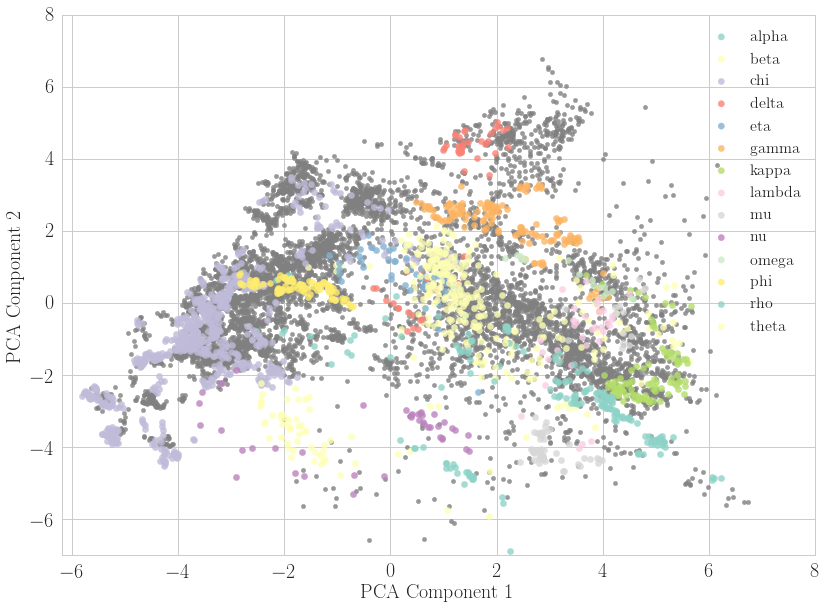

In [59]:
ax = grs1915_dataviz.features_pca(datadir, 1024., ranking=ranking)

One thing I'd also like to do is think about the *physical* differences between classes. There are some indications that these differences are due to stochastic versus chaotic versus deterministic processes. 

From Misra (2006): 
* **Chaotic**: beta, lambda, kappa, mu
* **deterministic**: theta, rho, alpha, nu, delta
* **stochastic**: phi, gamma, chi

Where do omega and eta lie in this? It looks like they were not part of the analysis. Can we infer where they should lie? Let's separate labels into the three new classes, but leave eta and omega where they are, then visualize the results:

In [62]:
labels_train = labels["train"]
labels_val = labels["val"]
labels_test = labels["test"]

chaotic = ["beta", "lambda", "kappa", "mu"]
deterministic = ["theta", "rho", "alpha", "nu", "delta"]
stochastic = ["phi", "gamma", "chi"]

labels_train_phys, labels_val_phys, labels_test_phys = [], [], []
for l in labels_train:
    if l in chaotic:
        labels_train_phys.append("chaotic")
    elif l in deterministic:
        labels_train_phys.append("deterministic")
    elif l in stochastic:
        labels_train_phys.append("stochastic")
    else:
        labels_train_phys.append(l)
        
for l in labels_test:
    if l in chaotic:
        labels_test_phys.append("chaotic")
    elif l in deterministic:
        labels_test_phys.append("deterministic")
    elif l in stochastic:
        labels_test_phys.append("stochastic")
    else:
        labels_test_phys.append(l)

for l in labels_val:
    if l in chaotic:
        labels_val_phys.append("chaotic")
    elif l in deterministic:
        labels_val_phys.append("deterministic")
    elif l in stochastic:
        labels_val_phys.append("stochastic")
    else:
        labels_val_phys.append(l)

 

In [67]:
labels_all_phys = np.hstack([labels_train_phys, labels_val_phys, labels_test_phys])
labels_unique_phys = np.unique(labels_all_phys)
labels_unique_phys = np.delete(labels_unique_phys, 0)
print("unique labels: " + str(labels_unique_phys))



unique labels: ['chaotic' 'deterministic' 'eta' 'omega' 'stochastic']


In [68]:
labels_phys = {"train":labels_train_phys,
              "test": labels_test_phys,
              "val": labels_val_phys}

Now we can redo the visualization:

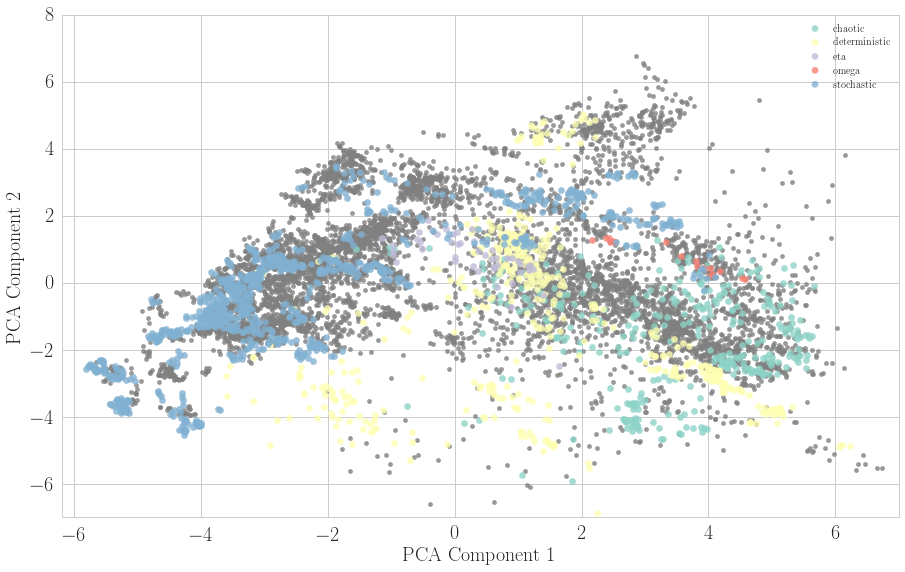

In [70]:
alpha=0.8
palette = "Set3"

sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# make a Figure object
fig, ax = plt.subplots(1,1,figsize=(15,9))

# first plot the unclassified examples:
ax.scatter(fscaled_pca[labels_all_phys == "None",0], fscaled_pca[labels_all_phys == "None",1], color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(labels_unique_phys))

for l, c in zip(labels_unique_phys, current_palette):
    ax.scatter(fscaled_pca[labels_all_phys == l,0], fscaled_pca[labels_all_phys == l,1], s=40,
               color=c, alpha=alpha, label=l)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(-6.2, 7.0)
plt.ylim(-7.0, 8.0)
plt.legend()



I think I want to make a Figure including both!

In [79]:
reload(grs1915_dataviz)

<module 'grs1915_dataviz' from 'grs1915_dataviz.py'>

delete_ind: [8032]
delete_ind_new: [1615]
delete_set: test
after removal: []


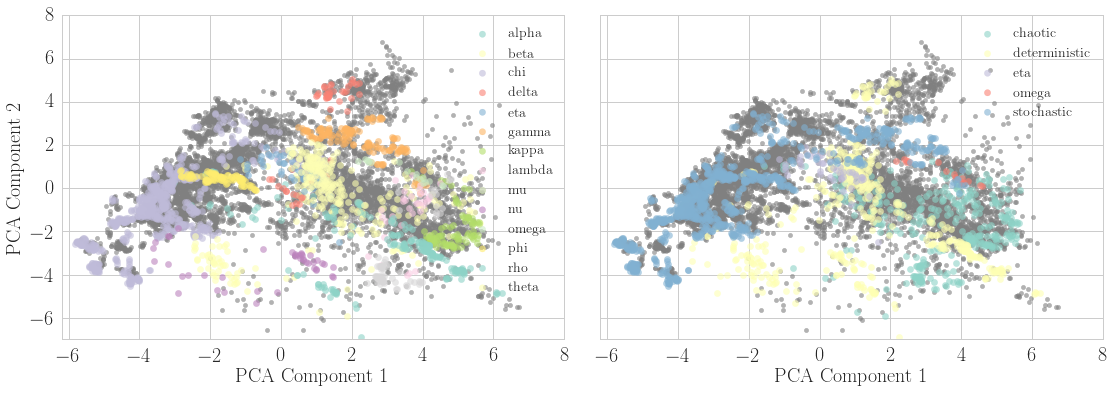

In [81]:
alpha=0.6
palette = "Set3"

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6), sharey=True)
ax1 = grs1915_dataviz.features_pca(datadir, 1024., ranking=ranking, ax=ax1,
                                  alpha=alpha, palette=palette)

sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# make a Figure object
#fig, ax = plt.subplots(1,1,figsize=(15,9))

# first plot the unclassified examples:
ax2.scatter(fscaled_pca[labels_all_phys == "None",0], fscaled_pca[labels_all_phys == "None",1], color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(labels_unique_phys))

for l, c in zip(labels_unique_phys, current_palette):
    ax2.scatter(fscaled_pca[labels_all_phys == l,0], fscaled_pca[labels_all_phys == l,1], s=40,
               color=c, alpha=alpha, label=l)

ax2.set_xlabel("PCA Component 1")
#ax2.set_ylabel("PCA Component 2")
ax2.set_xlim(-6.2, 8.0)
ax2.set_ylim(-7.0, 8.0)
ax2.legend(loc="upper right", prop={"size":14})

plt.tight_layout()
plt.savefig(datadir+"grs1915_features_pca.pdf", format="pdf")


Same plot, just with the dataviz function:

In [95]:
reload(feature_engineering)
reload(grs1915_dataviz)

<module 'grs1915_dataviz' from 'grs1915_dataviz.py'>

delete_ind: [8032]
delete_ind_new: [1615]
delete_set: test
after removal: []
physical labels: ['chaotic' 'deterministic' 'eta' 'omega' 'stochastic']


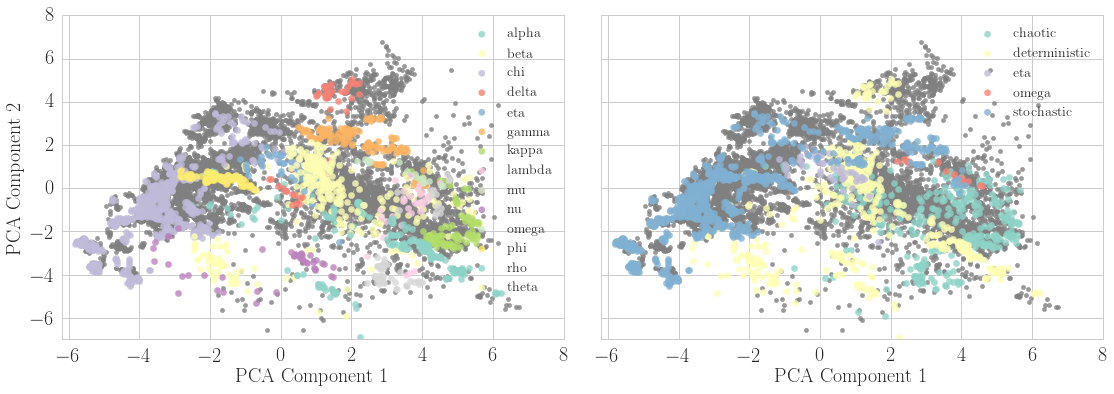

In [96]:
ax1, ax2 = grs1915_dataviz.features_pca(datadir, 1024., log_features=None, ranking=ranking, axes=None,
                 alpha=0.8, palette="Set3")

plt.savefig(datadir+"grs1915_features_pca.pdf", format="pdf")

Doesn't look so bad! Let's try t-SNE:

In [100]:
reload(grs1915_dataviz)

<module 'grs1915_dataviz' from 'grs1915_dataviz.py'>

In [109]:
fscaled_tsne = TSNE(n_components=2).fit_transform(fscaled_full[:,:10])

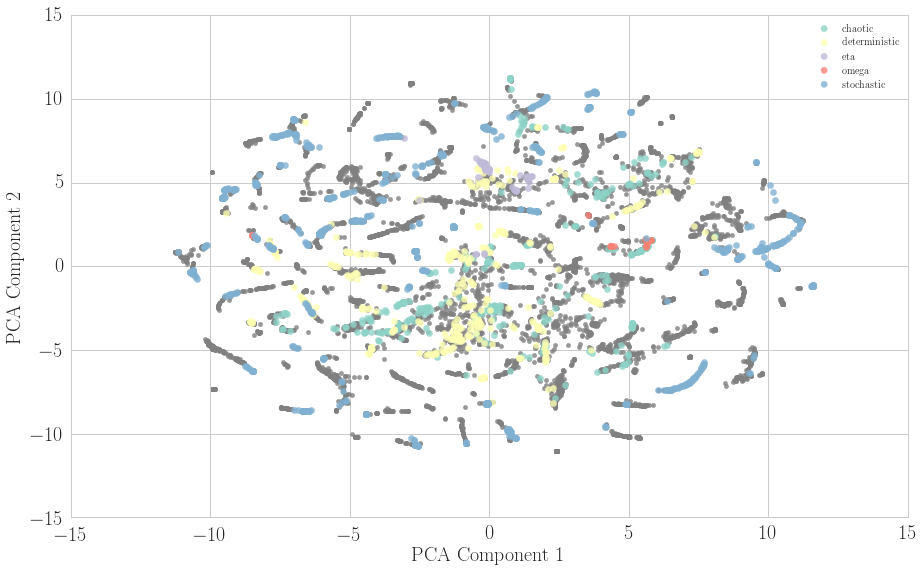

In [110]:
alpha=0.8
palette = "Set3"

sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# make a Figure object
fig, ax = plt.subplots(1,1,figsize=(15,9))

# first plot the unclassified examples:
ax.scatter(fscaled_tsne[labels_all_phys == "None",0], 
           fscaled_tsne[labels_all_phys == "None",1], 
           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(labels_unique_phys))

for l, c in zip(labels_unique_phys, current_palette):
    ax.scatter(fscaled_tsne[labels_all_phys == l,0], 
               fscaled_tsne[labels_all_phys == l,1], s=40,
               color=c, alpha=alpha, label=l)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
#plt.xlim(-6.2, 7.0)
#plt.ylim(-7.0, 8.0)
plt.legend()




In [112]:
reload(grs1915_dataviz)

<module 'grs1915_dataviz' from 'grs1915_dataviz.py'>

delete_ind: [8032]
delete_ind_new: [1615]
delete_set: test
after removal: []
physical labels: ['chaotic' 'deterministic' 'eta' 'omega' 'stochastic']


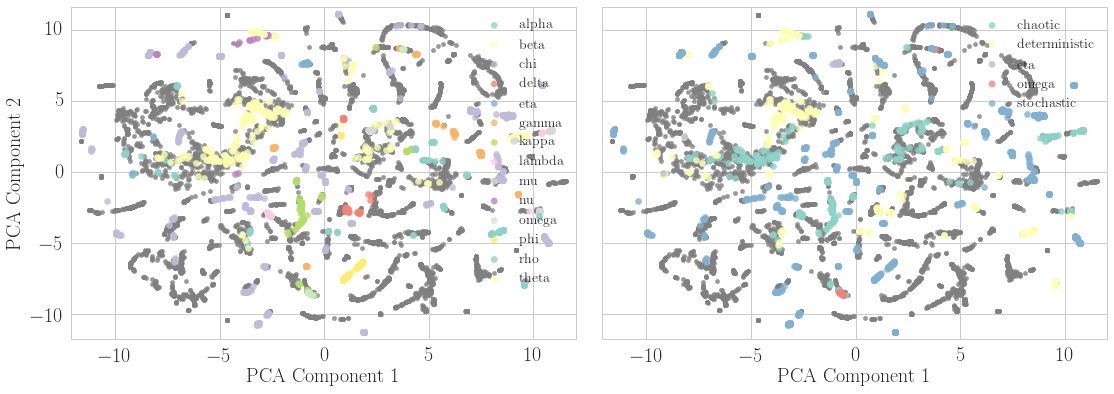

In [113]:
ax1, ax2 = grs1915_dataviz.features_pca(datadir, 1024., log_features=None, ranking=ranking, axes=None,
                 alpha=0.8, palette="Set3", algorithm="tsne")

plt.savefig(datadir+"grs1915_features_tsne.pdf", format="pdf")

That looks somewhat better! How about some classification?

First, let's get the **labelled** data out of their dictionaries:

In [114]:
fscaled_train = fscaled_lb["train"]
fscaled_test = fscaled_lb["test"]
fscaled_val = fscaled_lb["val"]

labels_train = labels_lb["train"]
labels_test = labels_lb["test"]
labels_val = labels_lb["val"]

Next, we're going to try the simplest algorithm we can: K-Nearest Neighbours.
We're going to cross-validate across some parameters (check documentation).

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

params = {'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]}#, 'max_features': }
grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, verbose=1, n_jobs=10)
grid.fit(fscaled_train, labels_train)


Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [116]:
print(grid.best_params_)
print(grid.score(fscaled_train, labels_train))
print(grid.score(fscaled_val, labels_val))


{'n_neighbors': 1}
1.0
0.930394431555


Plain nearest neighbour search gets us to $\sim 93\%$! Woo! Let's try Random Forests, which is a bit more robust.

In [119]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [7, 10, 15, 20, 30,40, 50, 100, 200, 500],
          'max_features':[2,3,4,5,6,7,8,10,12,14,16,17,18,19,20,22,24,26,28,30,32,34]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=1, n_jobs=10)
grid_rfc.fit(fscaled_train, labels_train)



Fitting 3 folds for each of 220 candidates, totalling 660 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   44.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 660 out of 660 | elapsed:  2.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'max_features': [2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32, 34], 'max_depth': [7, 10, 15, 20, 30, 40, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [120]:
print(grid_rfc.best_params_)
print(grid_rfc.score(fscaled_train, labels_train))
print(grid_rfc.score(fscaled_val, labels_val))

labels_rfc = grid_rfc.predict(fscaled_val)
labels_rfc_test = grid_rfc.predict(fscaled_test)

print("Test data set: " + str(grid_rfc.score(fscaled_test, labels_test)))

{'max_features': 3, 'max_depth': 100}
1.0
0.911832946636
Test data set: 0.895074946467


We can plot a confusion matrix to look at which classes tend to be confused:

[[  6   6   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0  31   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 220   0   0   0   0   0   0   0   0   0   0   6]
 [  0   0   0  16   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   9   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  15   0   0   0   0   0   0   0   0]
 [  0   4   0   0   0   0  16   0   0   0   2   0   0   0]
 [  0   0   0   0   0   0   0   6   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  13   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   4   0   0]
 [  0  13   0   0   0   0   0   0   0   0   0   0  26   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  27]]


([<matplotlib.axis.YTick at 0x7f4f27cd4690>,
 <a list of 14 Text yticklabel objects>)

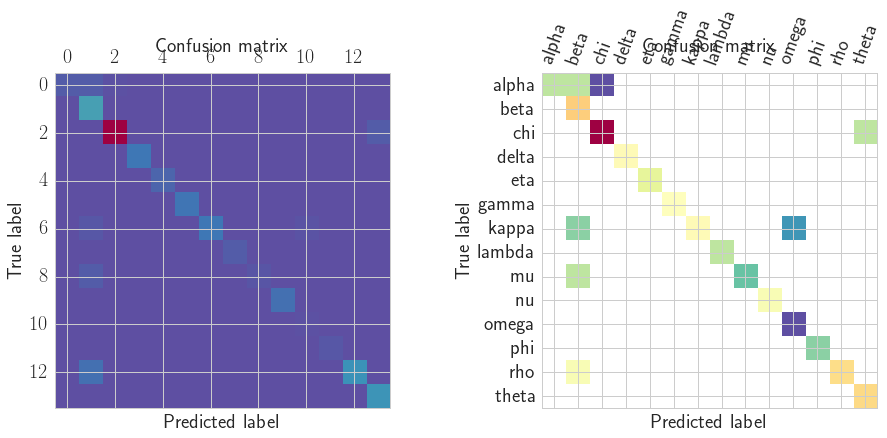

In [121]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

sns.set_style("white") 
unique_labels = np.unique(labels_val)
cm = confusion_matrix(labels_val, labels_rfc, labels=unique_labels)
print(cm)
ax1.matshow(cm, cmap=cmap.Spectral_r )
ax1.set_title('Confusion matrix')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)

cm_test = confusion_matrix(labels_test, labels_rfc_test, labels=unique_labels)
ax2.matshow(np.log(cm), cmap=cmap.Spectral_r )
ax2.set_title('Confusion matrix')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)



The classification is pretty good! ~90% are correctly identified. 
*


There are two possible explanations for these classifications:
1. There is some information in the data that our features do not capture
2. The human classification isn't perfect

In practice, it's probably a combination of both.

Let's make a Figure of publication:

In [156]:

unique_labels = np.unique(labels_val)
cm = confusion_matrix(labels_val, labels_rfc, labels=unique_labels)

cm


array([[  6,   6,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,  31,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0, 220,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          6],
       [  0,   0,   0,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   9,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,  15,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   4,   0,   0,   0,   0,  16,   0,   0,   0,   2,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   6,   0,   0,   0,   0,   0,
          0],
       [  0,   6,   0,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  13,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0, 

In [164]:
cm = cm + 1

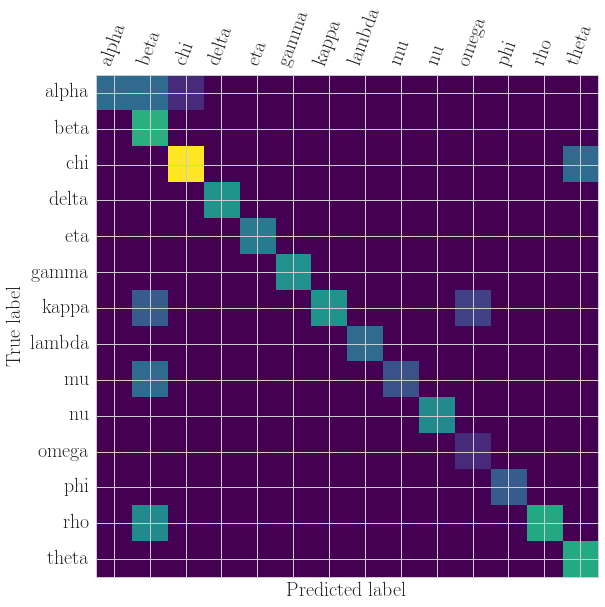

In [167]:

fig, ax1 = plt.subplots(1,1, figsize=(9,9))

sns.set_style("whitegrid") 
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax1.matshow(np.log(cm), cmap=cmap.viridis)
#ax1.set_title('Confusion matrix')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70);
plt.yticks(range(len(unique_labels)), unique_labels);

plt.savefig(datadir+"grs1915_supervised_cm.pdf", format="pdf")


In [122]:
labels_rfc_val = grid_rfc.predict(fscaled_val)


One useful diagnostic is to plot all the light curves that are confused and see whether we can see a consistent behaviour. 

In [123]:
misclassifieds = []
for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features_val, labels_rfc, labels_val, lc_val, \
                                            hr_val)):
    if lpredict == ltrue:
        continue
    else:
        misclassifieds.append([f, lpredict, ltrue, lc, hr])

In [ ]:
import powerspectrum
nexamples = 6


for j,m in enumerate(misclassifieds):
    pos_human = np.random.choice([0,3], p=[0.5, 0.5])
    pos_robot = int(3. - pos_human)
    
    f = m[0]
    lpredict = m[1]
    ltrue = m[2]
    times = m[3][0]
    counts = m[3][1]
    hr1 = m[4][0]
    hr2 = m[4][1]
    print("Predicted class is: " + str(lpredict))
    print("Human classified class is: " + str(ltrue))
    robot_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                 zip(labels_val, labels_rfc, lc_val, hr_val)\
                 if lt == lpredict ]
    human_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                 zip(labels_val, labels_rfc, lc_val, hr_val)\
                 if lt == ltrue ]
    
    #print("robot_classes: " + str([r[0] for r in robot_all]))
    #print("human classes: " + str([h[0] for h in human_all]))
    np.random.shuffle(robot_all)
    np.random.shuffle(human_all)
    robot_all = robot_all[:6]
    human_all = human_all[:6]
    
    sns.set_style("darkgrid")
    current_palette = sns.color_palette()
    fig = plt.figure(figsize=(10,15))
    
    def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
        #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
        ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
        ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
        ax.set_xlim([times[0], times[-1]])
        ax.set_ylim([0.0, 12000.0])
        #print("plotting in grid point " + str((xcoords[1], ycoords[1])))
    
        ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
        ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
        ax.set_xlim([.27, 0.85])
        ax.set_ylim([0.04, 0.7])
    
        #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
        ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
        dt = np.min(np.diff(times))
        ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
        ax.loglog(ps.freq[1:], ps.ps[1:], linestyle="steps-mid", rasterized=True)
        ax.set_xlim([ps.freq[1], ps.freq[-1]])
        ax.set_ylim([1.e-6, 10.])
    
        return
    
    ## first plot misclassified:
    plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)
    
    ## now plot examples
    for i in range(4):
        r = robot_all[i]
        h = human_all[i]
        #print(h[0])
        #print("human indices: " + str([ [i+3, i+3, i+3], [pos_human, pos_human+1, pos_human+2]]))
        #print("robot indices: " + str([[i+3, i+3, i+3], [pos_robot, pos_robot+1, pos_robot+2]]))
        plot_lcs(h[2][0], h[2][1], h[3][0], h[3][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
        plot_lcs(r[2][0], r[2][1], r[3][0], r[3][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)
        
    ax = plt.subplot2grid((9,6),(8,pos_human+1))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
    ax = plt.subplot2grid((9,6),(8,pos_robot+1))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
    #plt.show()
    plt.savefig(datadir+"misclassified%i.pdf"%j, format="pdf")
    plt.close()

In [ ]:
import powerspectrum

def plot_misclassifieds(features, trained_labels, real_labels, lc_all, hr_all,
                        nexamples=6, namestr="misclassified"):

    """
    Find all mis-classified light curves and plot them with examples of the real and false classes.
    """
    misclassifieds = []
    for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features, trained_labels, real_labels, lc_all, \
                                                hr_all)):
        if lpredict == ltrue:
            continue
        else:
            misclassifieds.append([f, lpredict, ltrue, lc, hr])

    for j,m in enumerate(misclassifieds):
        pos_human = np.random.choice([0,3], p=[0.5, 0.5])
        pos_robot = int(3. - pos_human)

        f = m[0]
        lpredict = m[1]
        ltrue = m[2]
        times = m[3][0]
        counts = m[3][1]
        hr1 = m[4][0]
        hr2 = m[4][1]
        print("Predicted class is: " + str(lpredict))
        print("Human classified class is: " + str(ltrue))
        robot_all = [[lp, lt, lc, hr] for lp, lt, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lt == lpredict ]
        human_all = [[lp, lt, lc, hr] for lp, lt, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lt == ltrue ]

        np.random.shuffle(robot_all)
        np.random.shuffle(human_all)
        robot_all = robot_all[:6]
        human_all = human_all[:6]

        sns.set_style("darkgrid")
        current_palette = sns.color_palette()
        fig = plt.figure(figsize=(10,15))

        def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
            #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
            ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
            ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
            ax.set_xlim([times[0], times[-1]])
            ax.set_ylim([0.0, 12000.0])
            #print("plotting in grid point " + str((xcoords[1], ycoords[1])))

            ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            ax.set_xlim([.27, 0.85])
            ax.set_ylim([0.04, 0.7])

            #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
            ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
            dt = np.min(np.diff(times))
            ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
            ax.loglog(ps.freq[1:], ps.ps[1:], linestyle="steps-mid", rasterized=True)
            ax.set_xlim([ps.freq[1], ps.freq[-1]])
            ax.set_ylim([1.e-6, 10.])

            return

        ## first plot misclassified:
        plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)

        ## now plot examples
        for i in range(4):
            r = robot_all[i]
            h = human_all[i]
            #print(h[0])
            #print("human indices: " + str([ [i+3, i+3, i+3], [pos_human, pos_human+1, pos_human+2]]))
            #print("robot indices: " + str([[i+3, i+3, i+3], [pos_robot, pos_robot+1, pos_robot+2]]))
            plot_lcs(h[2][0], h[2][1], h[3][0], h[3][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
            plot_lcs(r[2][0], r[2][1], r[3][0], r[3][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)

        ax = plt.subplot2grid((9,6),(8,pos_human+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
        ax = plt.subplot2grid((9,6),(8,pos_robot+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
        plt.savefig("misclassified%i.pdf"%j, format="pdf")
        plt.close()

## Classifying the entire data set

To compare with unsupervised methods, we're going to train on the entire supervised set, then use that to classify the unknown data points and plot a light curve.


### Human-classified Labels

Let's first start with the full 14 currently classified states:

In [130]:
fscaled_cls = fscaled_full[labels_all != "None"]
labels_cls = labels_all[labels_all != "None"]

from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [7, 10,12, 15, 20, 25,30,40, 50, 100, 200, 500], 
          'max_features':[2,3,4,5,6,7,8,10,12,14,16,18,20,22,24,26,28,30,32,34]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params, 
                        verbose=0, n_jobs=10)
grid_rfc.fit(fscaled_cls, labels_cls)
print(grid_rfc.best_params_)
print(grid_rfc.score(fscaled_cls, labels_cls))


{'max_features': 4, 'max_depth': 12}
1.0


In [131]:
print(grid_rfc.best_params_)
rfc = RandomForestClassifier(n_estimators=500,max_depth=grid_rfc.best_params_["max_depth"],
                            max_features=grid_rfc.best_params_["max_features"])
rfc.fit(fscaled_cls, labels_cls)

{'max_features': 4, 'max_depth': 12}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=4, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
#fscaled_all_full = scaler_train.transform(features_all_full)
labels_trained_full = rfc.predict(fscaled_full)

Test whether when predicting *everything*, it still predicts the training set correctly.

In [135]:
rfc.score(fscaled_cls, labels_cls)

1.0

Let's look at the distribution of states:

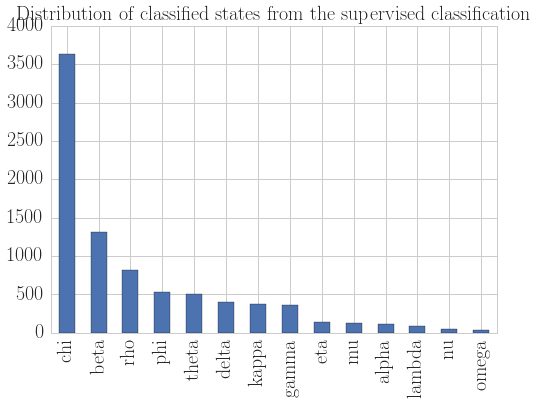

In [169]:
sns.set_style("whitegrid") 
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

st = pd.Series(labels_trained_full)
nstates = st.value_counts()
nstates.plot(kind='bar', color=sns.color_palette()[0])
plt.title("Distribution of classified states from the supervised classification")
plt.savefig(datadir+"grs1915_supervised_states_histogram.pdf", format="pdf")
#plt.close()


Let's redo the PCA Figure with the human versus machine classification:

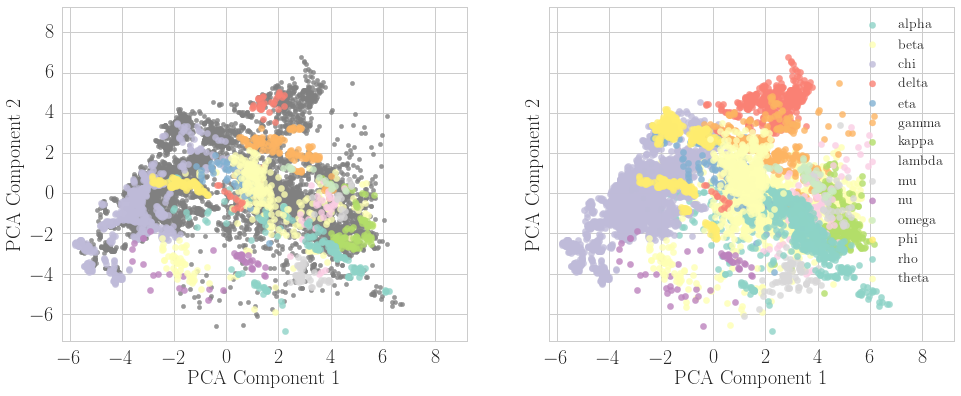

In [178]:
sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20)
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

unique_labels = np.unique(labels_all)
unique_labels = np.delete(unique_labels,
                          np.where(unique_labels == "None")[0])

# make a Figure object
fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True)

xlim = [np.min(fscaled_pca[:,0])-0.5, np.max(fscaled_pca[:,0])+2.5] # [-6.2, 8.0]
ylim = [np.min(fscaled_pca[:,1])-0.5, np.max(fscaled_pca[:,1])+2.5] # [-7.0, 8.0]
ax1, ax2 = axes[0], axes[1]

# first plot the unclassified examples:
ax1.scatter(fscaled_pca[labels_all == "None",0],
           fscaled_pca[labels_all == "None",1],
           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax1.scatter(fscaled_pca[labels_all == l,0],
               fscaled_pca[labels_all == l,1], s=40,
               color=c, alpha=alpha, label=l)

ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.legend(loc="upper right", prop={"size":14})


# first plot the unclassified examples:
#ax2.scatter(fscaled_pca[labels_trained_full == "None",0],
#           fscaled_pca[labels_train == "None",1],
#           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax2.scatter(fscaled_pca[labels_trained_full == l,0],
               fscaled_pca[labels_trained_full == l,1], s=40,
               color=c, alpha=alpha, label=l)

ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend(loc="upper right", prop={"size":14})

plt.savefig(datadir+"grs1915_supervised_pca_comparison.pdf", format="pdf")



Let's look what the states look like over time.

In [179]:
colors = sns.color_palette("Set3", 14)
pred_label_set = np.unique(labels_trained_full)
print(pred_label_set)
tstart_all = np.concatenate([tstart["train"], tstart["val"], tstart["test"]])

['alpha' 'beta' 'chi' 'delta' 'eta' 'gamma' 'kappa' 'lambda' 'mu' 'nu'
 'omega' 'phi' 'rho' 'theta']


In [182]:
asm = np.loadtxt(datadir+"grs1915_asm_lc.txt",skiprows=5)
asm_time = asm[:,0]
asm_cr = asm[:,1]
asm_total = asm_time[-1]-asm_time[0]
print("The ASM light curve covers a total of %i days"%asm_total)

mjdrefi = 49353. 
tstart_all_days = tstart_all/(60.*60.*24.)
tstart_all_mjd = tstart_all_days + mjdrefi



The ASM light curve covers a total of 5725 days


In [184]:
tstart_all_mjd

array([ 50471.21064887,  50471.21361183,  50471.21657479, ...,
        52365.8055549 ,  52365.80851787,  52365.81148085])

I am on plot 0.
I am on plot 1.
I am on plot 2.
I am on plot 3.
I am on plot 4.
I am on plot 5.
I am on plot 6.
I am on plot 7.
I am on plot 8.
I am on plot 9.
I am on plot 10.


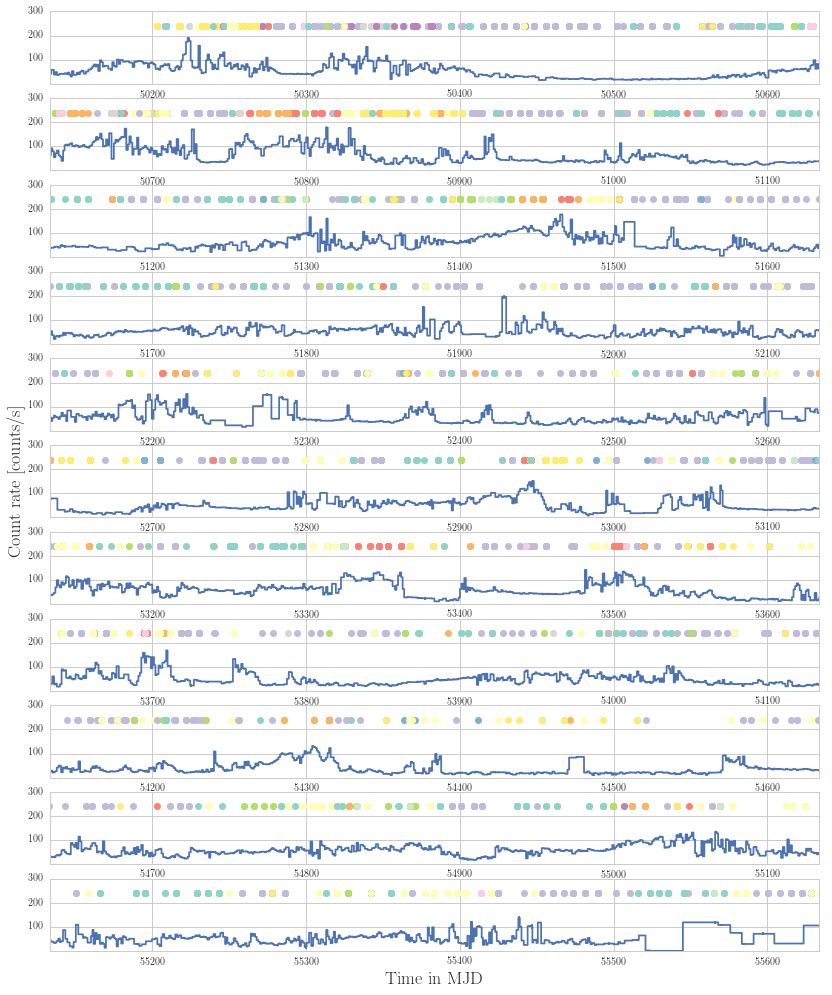

In [188]:

## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len
i = 0

fig = plt.figure(figsize=(12,15))

sns.set_style("white")

ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("whitegrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

current_palette = sns.color_palette(palette, len(pred_label_set))
while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    ax1 = fig.add_subplot(11,1,i+1)
    ax1.errorbar(asm[:,0], asm[:,1], yerr = asm[:,2], linestyle="steps-mid")
    for k, col in zip(pred_label_set, colors):
        tstart_members = tstart_all_mjd[labels_trained_full == k]
        #print(len(my_members))
        #cluster_center = cluster_centers[k]
        ax1.plot(tstart_members, np.ones(len(tstart_members))*240.,"o", color=col, label="state " + str(k))
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    plt.yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1

ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

#plt.savefig(paperdir+"grs1915_asm_lc_all.pdf", format="pdf")
#plt.close()

### Using the Physical Labels

What about the classification with the "physical" labels?

In [203]:
labels_train_phys = np.array(labels_phys["train"])
labels_test_phys = np.array(labels_phys["test"])
labels_val_phys = np.array(labels_phys["val"])

Note: at the moment, omega and eta are still separate classes within this scheme. 

For practical purposes, I should add them to the "None" list, so that I can check what classes they will ultimately belong to:

In [204]:
unphysical = ["eta", "omega"]

for i,l in enumerate(labels_train_phys):
    if l in unphysical:
        labels_train_phys[i] = "None"

for i,l in enumerate(labels_val_phys):
    if l in unphysical:
        labels_val_phys[i] = "None"

for i,l in enumerate(labels_test_phys):
    if l in unphysical:
        labels_test_phys[i] = "None"



In [205]:
labels_unique_phys = np.unique(labels_train_phys)
print("unique physical labels: " + str(labels_unique_phys))

unique physical labels: ['None' 'chaotic' 'deterministic' 'stochastic']


In [220]:
labels_train = labels_lb["train"]
labels_test = labels_lb["test"]
labels_val = labels_lb["val"]


In [226]:
fscaled_train_phys = fscaled_train[(labels_train != "eta") & (labels_train != "omega")]
fscaled_test_phys = fscaled_test[(labels_test != "eta") & (labels_test != "omega")]
fscaled_val_phys = fscaled_val[(labels_val != "eta") & (labels_val != "omega")]

In [231]:
labels_train = labels_train_phys[labels_train_phys != "None"]
labels_test = labels_test_phys[labels_test_phys != "None"]
labels_val = labels_val_phys[labels_val_phys != "None"]

params = {'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]}#, 
          #'max_features': [1,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, verbose=1, n_jobs=10)
grid.fit(fscaled_train_phys, labels_train)



Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  42 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [232]:
print(grid.best_params_)
print(grid.score(fscaled_train_phys, labels_train))
print(grid.score(fscaled_val_phys, labels_val))



{'n_neighbors': 3}
0.992513368984
0.935866983373


That's a pretty good performance, too.
Let's also do the Random Forest:

In [233]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [7, 10, 15, 20, 30,40, 50, 100, 200, 500],
          'max_features':[2,3,4,5,6,7,8,10,12,14,16,17,18,19,20,22,24,26,28,30,32,34]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=1, n_jobs=10)
grid_rfc.fit(fscaled_train_phys, labels_train)




Fitting 3 folds for each of 220 candidates, totalling 660 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   36.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 660 out of 660 | elapsed:  2.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'max_features': [2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32, 34], 'max_depth': [7, 10, 15, 20, 30, 40, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [234]:
print(grid_rfc.best_params_)
print(grid_rfc.score(fscaled_train_phys, labels_train))
print(grid_rfc.score(fscaled_val_phys, labels_val))

labels_rfc = grid_rfc.predict(fscaled_val_phys)
labels_rfc_test = grid_rfc.predict(fscaled_test_phys)

print("Test data set: " + str(grid_rfc.score(fscaled_test_phys, labels_test)))

{'max_features': 2, 'max_depth': 15}
1.0
0.964370546318
Test data set: 0.924731182796


What does the confusion matrix look like for this problem?

[[ 62   6   0]
 [  2 105   1]
 [  0   6 239]]


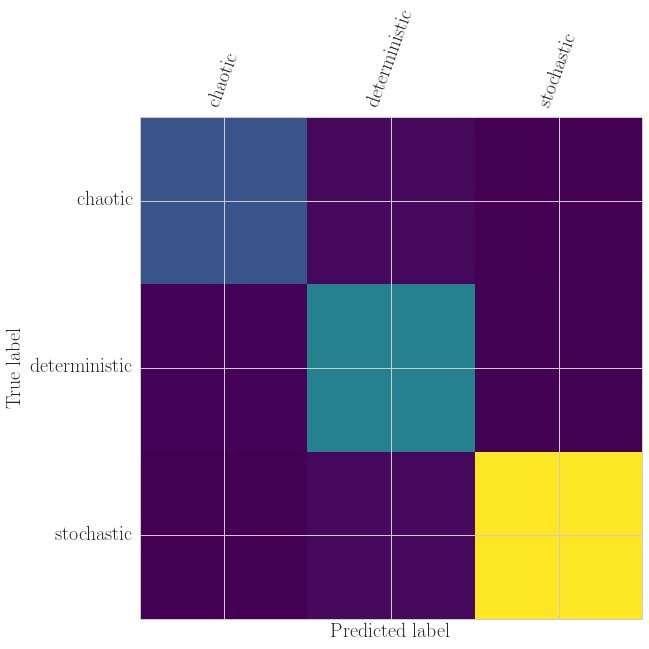

In [239]:

unique_labels = np.unique(labels_val)
cm = confusion_matrix(labels_val, labels_rfc, labels=unique_labels)


fig, ax1 = plt.subplots(1,1, figsize=(9,9))

sns.set_style("whitegrid") 
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
print(cm)
ax1.matshow(cm, cmap=cmap.viridis)
#ax1.set_title('Confusion matrix')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70);
plt.yticks(range(len(unique_labels)), unique_labels);

plt.savefig(datadir+"grs1915_supervised__phys_cm.pdf", format="pdf")



There's only very few samples confused. Let's re-do the plot with the PCA.

First, we need to classify the entire data set:

In [240]:
labels_phys = np.hstack([labels_train_phys, labels_val_phys, labels_test_phys])

In [242]:
fscaled_cls = fscaled_full[labels_phys != "None"]
labels_cls = labels_phys[labels_phys != "None"]

params = {'max_depth': [7, 10,12, 15, 20, 25,30,40, 50, 100, 200, 500], 
          'max_features':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params, 
                        verbose=0, n_jobs=10)
grid_rfc.fit(fscaled_cls, labels_cls)
print(grid_rfc.best_params_)
print(grid_rfc.score(fscaled_cls, labels_cls))



{'max_features': 4, 'max_depth': 25}
1.0


In [243]:
print(grid_rfc.best_params_)
rfc = RandomForestClassifier(n_estimators=500,max_depth=grid_rfc.best_params_["max_depth"],
                            max_features=grid_rfc.best_params_["max_features"])
rfc.fit(fscaled_cls, labels_cls)

{'max_features': 4, 'max_depth': 25}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=4, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [244]:
#fscaled_all_full = scaler_train.transform(features_all_full)
labels_trained_full = rfc.predict(fscaled_full)

In [245]:
rfc.score(fscaled_cls, labels_cls)

1.0

Like above, we'll look at the distributions of states:

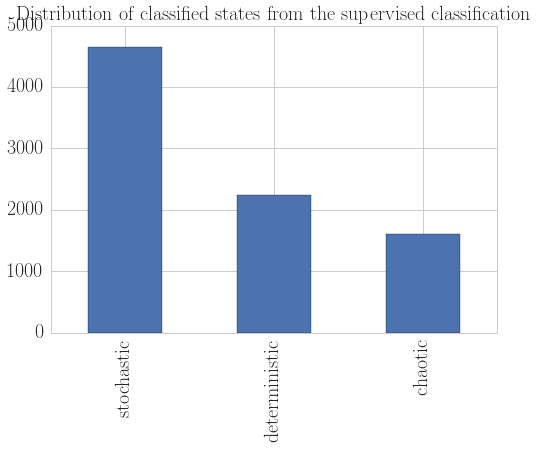

In [247]:
sns.set_style("whitegrid") 
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

st = pd.Series(labels_trained_full)
nstates = st.value_counts()
nstates.plot(kind='bar', color=sns.color_palette()[0])
plt.title("Distribution of classified states from the supervised classification")
plt.savefig(datadir+"grs1915_supervised_states_phys_histogram.pdf", format="pdf")
#plt.close()



Now we're ready to re-do the PCA Figure:

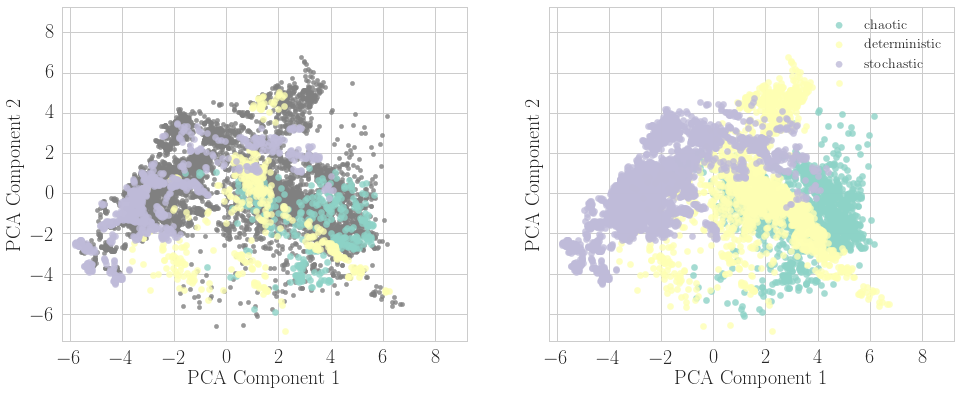

In [249]:
sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20)
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

unique_labels = np.unique(labels_phys)
unique_labels = np.delete(unique_labels,
                          np.where(unique_labels == "None")[0])

# make a Figure object
fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True)

xlim = [np.min(fscaled_pca[:,0])-0.5, np.max(fscaled_pca[:,0])+2.5] # [-6.2, 8.0]
ylim = [np.min(fscaled_pca[:,1])-0.5, np.max(fscaled_pca[:,1])+2.5] # [-7.0, 8.0]
ax1, ax2 = axes[0], axes[1]

# first plot the unclassified examples:
ax1.scatter(fscaled_pca[labels_phys == "None",0],
           fscaled_pca[labels_phys == "None",1],
           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax1.scatter(fscaled_pca[labels_phys == l,0],
               fscaled_pca[labels_phys == l,1], s=40,
               color=c, alpha=alpha, label=l)

ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.legend(loc="upper right", prop={"size":14})


# first plot the unclassified examples:
#ax2.scatter(fscaled_pca[labels_trained_full == "None",0],
#           fscaled_pca[labels_train == "None",1],
#           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax2.scatter(fscaled_pca[labels_trained_full == l,0],
               fscaled_pca[labels_trained_full == l,1], s=40,
               color=c, alpha=alpha, label=l)

ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend(loc="upper right", prop={"size":14})

plt.savefig(datadir+"grs1915_supervised_pca_phys_comparison.pdf", format="pdf")




Again, we'd like to see what the states look like over time:

In [253]:
pred_label_set

array(['chaotic', 'deterministic', 'stochastic'], 
      dtype='|S13')

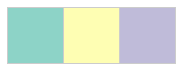

In [254]:
current_palette = sns.color_palette(palette, len(pred_label_set))
sns.palplot(current_palette)

['chaotic' 'deterministic' 'stochastic']
I am on plot 0.
I am on plot 1.
I am on plot 2.
I am on plot 3.
I am on plot 4.
I am on plot 5.
I am on plot 6.
I am on plot 7.
I am on plot 8.
I am on plot 9.
I am on plot 10.


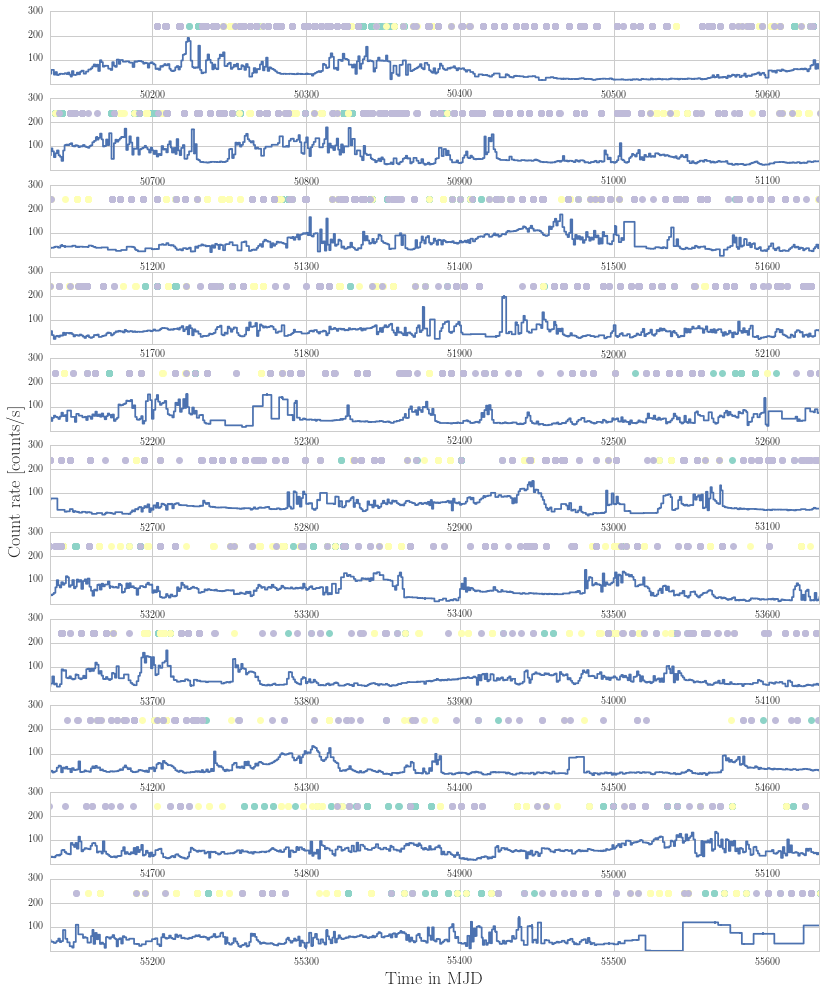

In [256]:
colors = sns.color_palette("Set3", 3)
pred_label_set = np.unique(labels_trained_full)
print(pred_label_set)
tstart_all = np.concatenate([tstart["train"], tstart["val"], tstart["test"]])
## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len
i = 0

fig = plt.figure(figsize=(12,15))

sns.set_style("white")

ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("whitegrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    ax1 = fig.add_subplot(11,1,i+1)
    ax1.errorbar(asm[:,0], asm[:,1], yerr = asm[:,2], linestyle="steps-mid")
    for k, col in zip(pred_label_set, colors):
        tstart_members = tstart_all_mjd[labels_trained_full == k]
        #cluster_center = cluster_centers[k]
        ax1.plot(tstart_members, np.ones(len(tstart_members))*240.,"o", color=col, label="state " + str(k))
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    plt.yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1

ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(datadir+"grs1915_asm_lc_all_phys.pdf", format="pdf")
#plt.close()

Which states are eta and omega closest to?

In [258]:
labels_eta_omega = labels_all[(labels_all == "eta") | (labels_all == "omega")]
labels_eta_omega_phys = labels_trained_full[(labels_all == "eta") | (labels_all == "omega")]

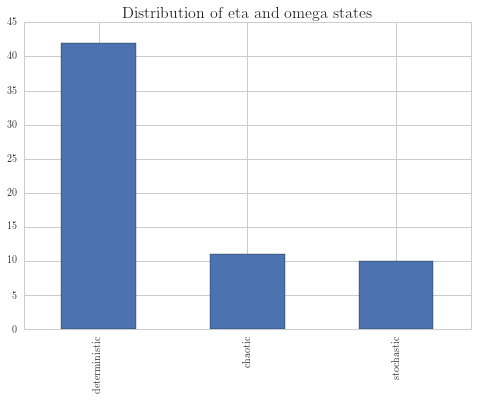

In [261]:
st = pd.Series(labels_eta_omega_phys)
nstates = st.value_counts()
nstates.plot(kind='bar', color=sns.color_palette()[0])
plt.title("Distribution of eta and omega states")

So most of them seem deterministic, with a minority in the other classes. Hmm.